In [1]:
!python --version

Python 3.9.12


In [2]:
# Import libraries necessary for this project
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import re
import string
import time
import gensim
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS
import wordcloud
from wordcloud import WordCloud

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# Load the courses and jobs datasets

job_desc_df = pd.read_excel('job_descriptions.xlsx')
udemy_df = pd.read_csv('udemy_master_df.csv')

In [5]:
print("udemy dataset has {} data points with {} variables each.".format(*udemy_df.shape))
print("jobs dataset has {} data points with {} variables each.".format(*job_desc_df.shape))

udemy dataset has 44635 data points with 9 variables each.
jobs dataset has 19265 data points with 8 variables each.


## Data Exploration

In [6]:
# Let's have a look at the first 3 rows of the udemy dataset
udemy_df.head(3)

,Unnamed: 0,index,Title,Summary,Enrollment,Stars,Rating,Link,Category
0,0,0,The Complete SQL Bootcamp 2020: Go from Zero to Hero,Become an expert at SQL!,301243,4.7,79919,https://www.udemy.com/course/the-complete-sql-bootcamp/,business
1,1,1,Tableau 2020 A-Z: Hands-On Tableau Training for Data Science,Learn Tableau 2020 for data science step by step. Real-life data analytics exercises & quizzes included. Learn by doing!,211674,4.6,55582,https://www.udemy.com/course/tableau10/,business
2,2,2,PMP Exam Prep Seminar - PMBOK Guide 6,PMP Exam Prep Seminar - Earn 35 PDUs by completing the entire PMP course,157957,4.6,53858,https://www.udemy.com/course/pmp-pmbok6-35-pdus/,business


In [7]:
# Let's have a look at the first 3 rows of the jobs dataset
job_desc_df.head(3)

,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,"Direct or coordinate an organization's financial or budget activities to fund operations, maximize investments, or increase efficiency.",Core,87.0,07/2014,Incumbent
1,11-1011.00,Chief Executives,8831,Appoint department heads or managers and assign or delegate responsibilities to them.,Core,87.0,07/2014,Incumbent
2,11-1011.00,Chief Executives,8825,"Analyze operations to evaluate performance of a company or its staff in meeting objectives or to determine areas of potential cost reduction, program improvement, or policy change.",Core,87.0,07/2014,Incumbent


In [8]:
# checking for unique records 

job_desc_df.groupby(['Title'])['Title'].count()  # duplicates noted in dataset given the length.

Title
Accountants and Auditors                                              30
Actors                                                                19
Actuaries                                                             15
Acupuncturists                                                        18
Acute Care Nurses                                                     27
                                                                      ..
Wind Turbine Service Technicians                                      13
Woodworking Machine Setters, Operators, and Tenders, Except Sawing    26
Word Processors and Typists                                           20
Writers and Authors                                                   20
Zoologists and Wildlife Biologists                                    14
Name: Title, Length: 923, dtype: int64

In [9]:
# checking for unique records 

udemy_df.groupby(['Title'])['Title'].count()  # duplicates noted in dataset given the length. Also noted foriegn characters 

Title
 10 Ritz-Carlton Marketing Secrets to Guarantee...          1
 Adobe Animate CC (Scripting): HTML5 (Español)              1
 Adobe Photoshop Focus Projects Course                      1
 Affiliate Marketing - WHAT It Takes To Get To 500 A Day    1
 Affinity Designer - making seamless patterns               1
                                                           ..
６時間でインターバンク市場を攻略！最短距離でトレード基礎力                               1
７日でマスター ビギナー向け Adobe Illustrator　どきどきセミナー                   1
９８３ｍメンバーズ倶楽部の成功しやすいアフィリエイト総合講座                              1
ＦＸで勝てない人はチャートを見るな！　自動売買ソフトをつくろう！                            1
ＳｐｒｉｔｅＳｔｕｄｉｏ（スプライトスタジオ）で学ぶ、２Ｄアニメーション制作講座                    1
Name: Title, Length: 41071, dtype: int64

### Exploring the course dataset

In [10]:
# lets look at some summary statistics of the course dataset, specifically stars and ratings 

udemy_df.describe() #average stars is 4.2 and the average ratings is 27. wide variation noted 

,Unnamed: 0,index,Enrollment,Stars,Rating
count,44635.000000,44635.000000,4.463500e+04,44635.000000,44635.000000
mean,4590.184183,4590.184183,4.011324e+03,3.870158,326.038468
std,2773.017640,2773.017640,1.603479e+04,1.109503,3083.202528
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2218.500000,2218.500000,7.500000e+01,3.700000,8.000000
50%,4450.000000,4450.000000,5.790000e+02,4.200000,27.000000
75%,6881.000000,6881.000000,2.755000e+03,4.500000,99.000000
max,9969.000000,9969.000000,1.100093e+06,5.000000,318066.000000


In [11]:
udemy_df.nunique(axis = 0)

Unnamed: 0     9970
index          9970
Title         41071
Summary       40549
Enrollment    10401
Stars            43
Rating         2547
Link          41225
Category          9
dtype: int64

In [12]:
udemy_df.isnull().sum()

Unnamed: 0     0
index          0
Title          0
Summary       10
Enrollment     0
Stars          0
Rating         0
Link           0
Category       0
dtype: int64

In [13]:
udemy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44635 entries, 0 to 44634
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  44635 non-null  int64  
 1   index       44635 non-null  int64  
 2   Title       44635 non-null  object 
 3   Summary     44625 non-null  object 
 4   Enrollment  44635 non-null  int64  
 5   Stars       44635 non-null  float64
 6   Rating      44635 non-null  int64  
 7   Link        44635 non-null  object 
 8   Category    44635 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 3.1+ MB


In [14]:
course_df = udemy_df.copy()

In [15]:
course_df = course_df.drop(columns = ['Unnamed: 0', 'index'])
course_df.head()

,Title,Summary,Enrollment,Stars,Rating,Link,Category
0,The Complete SQL Bootcamp 2020: Go from Zero to Hero,Become an expert at SQL!,301243,4.7,79919,https://www.udemy.com/course/the-complete-sql-bootcamp/,business
1,Tableau 2020 A-Z: Hands-On Tableau Training for Data Science,Learn Tableau 2020 for data science step by step. Real-life data analytics exercises & quizzes included. Learn by doing!,211674,4.6,55582,https://www.udemy.com/course/tableau10/,business
2,PMP Exam Prep Seminar - PMBOK Guide 6,PMP Exam Prep Seminar - Earn 35 PDUs by completing the entire PMP course,157957,4.6,53858,https://www.udemy.com/course/pmp-pmbok6-35-pdus/,business
3,The Complete Financial Analyst Course 2020,"Excel, Accounting, Financial Statement Analysis, Business Analysis, Financial Math, PowerPoint: Everything is Included!",249097,4.5,47415,https://www.udemy.com/course/the-complete-financial-analyst-course/,business
4,An Entire MBA in 1 Course:Award Winning Business School Prof,** #1 Best Selling Business Course! ** Everything You Need to Know About Business from Start-up to IPO,376913,4.5,42101,https://www.udemy.com/course/an-entire-mba-in-1-courseaward-winning-business-school-prof/,business


In [16]:
# Let's get the length of the titles and summaries

course_df.dropna(inplace=True)
course_df.isnull().sum()

course_df['course_title_length'] = course_df['Title'].apply(len)
course_df['course_summary_length'] = course_df['Summary'].apply(len)

In [17]:
course_df[['course_title_length', 'course_summary_length']].describe()

,course_title_length,course_summary_length
count,44625.000000,44625.000000
mean,46.051608,86.392314
std,12.430165,30.081400
min,3.000000,1.000000
25%,37.000000,63.000000
50%,49.000000,94.000000
75%,57.000000,114.000000
max,89.000000,163.000000


In [18]:
# Let's see the shortest title

course_df[course_df['course_title_length'] == 3.0]['Title'].iloc[0]

'CSS'

In [19]:
# Let's see the longest title

course_df[course_df['course_title_length'] == 89.0]['Title'].iloc[0]

'BDD in C# - using Specflow (Cucumber) to develop a REST API and automate software testing'

In [20]:
# Let's see the shortest summary

course_df[course_df['course_summary_length'] == 1]['Title'].iloc[0]

'Job Design, Compensation and Benefits'

In [21]:
# Let's see the longest summary

course_df[course_df['course_summary_length'] == 163]['Title'].iloc[0]

'BDD in C# - using Specflow (Cucumber) to develop a REST API and automate software testing'

<AxesSubplot:xlabel='course_summary_length', ylabel='Count'>

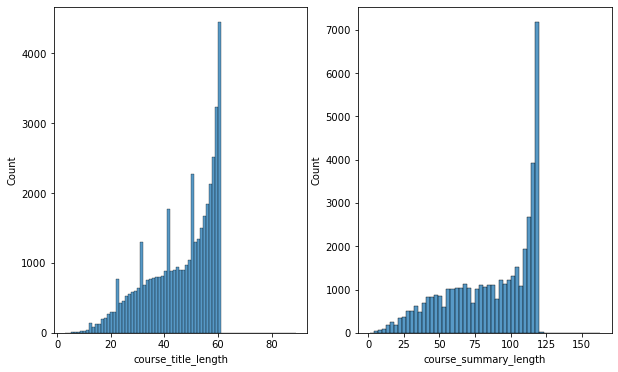

In [22]:
# let's plot a histogram of title and summary lenghs

fig, axs = plt.subplots(ncols=2,figsize=[10,6])

sns.histplot(data = course_df, x = course_df['course_title_length'], ax = axs[0])
sns.histplot(data = course_df, x = course_df['course_summary_length'], ax = axs[1])


<AxesSubplot:xlabel='Stars', ylabel='Count'>

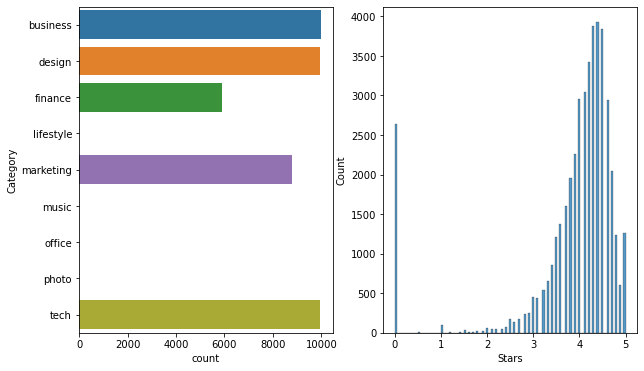

In [23]:
# Lets visualise the categories, stars and ratings

fig, axs = plt.subplots(ncols=2,figsize=[10,6])

sns.countplot(data = course_df, y = course_df['Category'], ax = axs[0])
sns.histplot(data = course_df, x = course_df['Stars'], ax = axs[1])

In [24]:
len(course_df[course_df['Category']=='lifestyle'])

16

In [27]:
#lets look at what languages are in the course dataset
from langdetect import detect

def language_detect(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [28]:
#apply the function to the dataset
course_df['language'] = course_df['Summary'].apply(language_detect)

In [29]:
df = course_df['language'].value_counts().rename_axis('language').reset_index(name = 'counts')
df

,language,counts
0,en,35861
1,pt,2008
2,es,1829
3,de,801
4,fr,708
5,tr,670
6,ja,614
7,it,546
8,ar,316
9,ru,217


<AxesSubplot:xlabel='count', ylabel='language'>

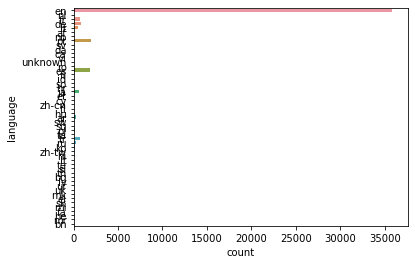

In [30]:
#lets visualize the data
sns.countplot(data = course_df, y = course_df['language'])

In [31]:
#palette_color = sns.color_palette('pastel')

#labels = df['language']
#size = df['counts']

#plt.pie(size, labels = labels, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
#my_circle = plt.Circle( (0,0), 0.7, color = 'white')
#p = plt.gcf()
#p.gca().add_artist(my_circle)

#plt.show()

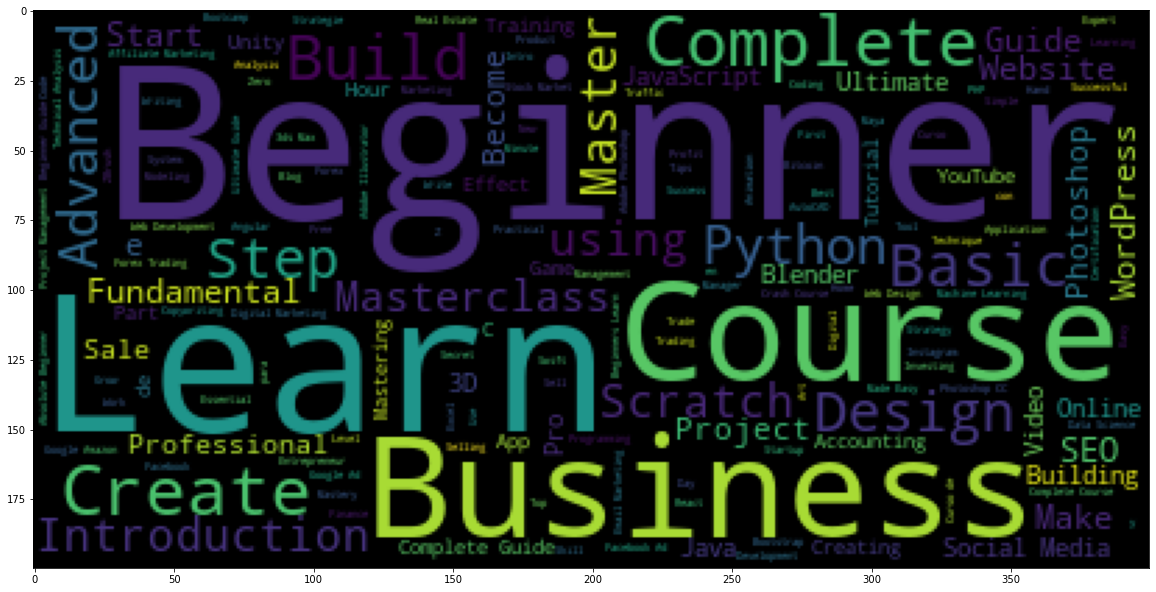

In [32]:
#creating a word cloud for Titles

titles = course_df['Title'].tolist()
titles_as_one_string =" ".join(titles)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(titles_as_one_string))

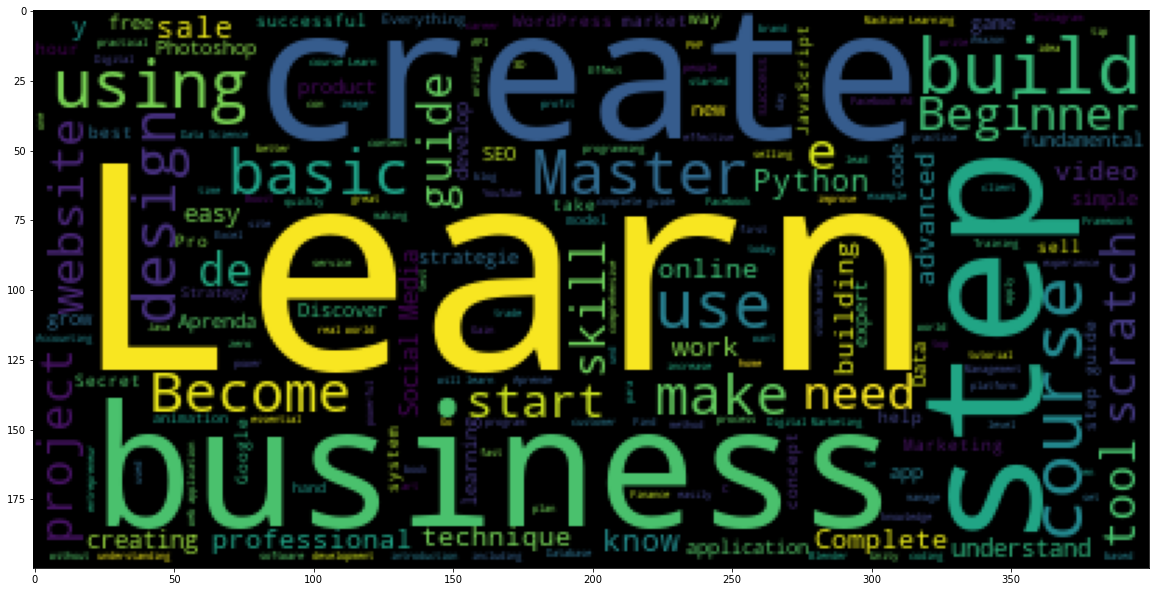

In [33]:
#creating a word cloud for Summary

descriptions = course_df['Summary'].tolist()
descriptions_as_one_string =" ".join(descriptions)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(descriptions_as_one_string))

In [34]:
# From the word clouds above, title seems to be more representative of skills in course. 
#This insight might be useful when creating the recommender

In [35]:
#make all reviews lowercase.
course_df['Summary_text'] = course_df['Summary'].apply(lambda x: x.lower())

#make all course titles lowercase
course_df['Title_text'] = course_df['Title'].apply(lambda x: x.lower())

In [36]:
#A contractions dictionary from Wikipedia found on Stack Overflow for expanding contractions: 
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [38]:
#This code is code to expand contractions in text created by Abhishek Sharma:
#https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
# expansion of contractions allows for better text analysis because contractions are used to reduce speaking and writing time 
#Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

#Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
course_df['Summary_text']= course_df['Summary_text'].apply(lambda x:expand_contractions(x))
course_df['Title_text']= course_df['Title_text'].apply(lambda x:expand_contractions(x))

In [39]:
# creating  a function for tokenization

def clean_tokenize_text(df,column, token_column_name):
    """
    
    This function cleans and tokenizes the text in the column specified 

        - strip punctuation
        - remove multiple whitespace
        - remove numeric characters
        - tokenize words
        - return a lower-case stemmed version of the text
        - remove common STOPWORDS (imported from gensim's Stone, Denis, Kwantes (2010) dataset)
        - remove CUSTOM_STOP_WORDS, defined above
 
    """
    df[column] = df[column].astype(str)
      
    #apply gensim default preprocess
    df[token_column_name] = df[column].apply(lambda x: preprocess_string(x))
    
    #remove gensim stop words
    df[token_column_name] = df[token_column_name].apply(lambda x: [item for item in x if item not in STOPWORDS])
    
    #remove custom stop words
    df[token_column_name] = df[token_column_name].apply(lambda x: [item for item in x if item not in CUSTOM_STOP_WORDS])

    
    return df

In [40]:
CUSTOM_STOP_WORDS = ['Learn', 'Beginner', 'Course', 'Create']  # some custom stop words that make not be in the stop words corpus

title_tokens_udemy_df = clean_tokenize_text(course_df,'Title_text', 'course_title_tokens')
title_tokens_udemy_df[['Title', 'course_title_tokens']].head()

,Title,course_title_tokens
0,The Complete SQL Bootcamp 2020: Go from Zero to Hero,"[complet, sql, bootcamp, zero, hero]"
1,Tableau 2020 A-Z: Hands-On Tableau Training for Data Science,"[tableau, hand, tableau, train, data, scienc]"
2,PMP Exam Prep Seminar - PMBOK Guide 6,"[pmp, exam, prep, seminar, pmbok, guid]"
3,The Complete Financial Analyst Course 2020,"[complet, financi, analyst, cours]"
4,An Entire MBA in 1 Course:Award Winning Business School Prof,"[entir, mba, cours, award, win, busi, school, prof]"


#### Performing Non-Negtaive Matrix Factorization to get topic groups based on title

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

tfidf = TfidfVectorizer(max_df=0.95, 
                        min_df=2, 
                        lowercase = True, 
                        stop_words="english",
                        ngram_range = (1,2), # include 2-word phrases
                        )

dtm = tfidf.fit_transform(title_tokens_udemy_df['course_title_tokens'].apply(lambda x: ' '.join(x)))

# we will choose 5 topics to represent the 5 categories of courses 
nmf_model = NMF(n_components=5, random_state=42)

nmf_model.fit(dtm)

C:\Users\Home\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=5, random_state=42)

In [42]:
# grabbing top 8 words per topic

for index,topic in enumerate(nmf_model.components_):
    print(f"The top 8 words for topric # {index}")
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-8:]])
    print('\n')

The top 8 words for topric # 0
['beginn guid', 'cours beginn', 'advanc', 'trade', 'guid', 'complet', 'cours', 'beginn']


The top 8 words for topric # 1


C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['email', 'social media', 'media', 'social', 'facebook', 'digit market', 'digit', 'market']


The top 8 words for topric # 2
['learn python', 'scratch', 'data', 'program', 'machin learn', 'machin', 'python', 'learn']


The top 8 words for topric # 3
['adob illustr', 'creat', 'develop', 'illustr', 'web', 'adob', 'photoshop', 'design']


The top 8 words for topric # 4
['success', 'build', 'onlin', 'manag', 'start', 'step step', 'step', 'busi']




In [43]:
description_tokens_udemy_df = clean_tokenize_text(course_df,'Summary_text', 'course_description_tokens')
description_tokens_udemy_df[['Summary_text', 'course_description_tokens']].head()

,Summary_text,course_description_tokens
0,become an expert at sql!,"[expert, sql]"
1,learn tableau 2020 for data science step by step. real-life data analytics exercises & quizzes included. learn by doing!,"[learn, tableau, data, scienc, step, step, real, life, data, analyt, exercis, quizz, includ, learn]"
2,pmp exam prep seminar - earn 35 pdus by completing the entire pmp course,"[pmp, exam, prep, seminar, earn, pdu, complet, entir, pmp, cours]"
3,"excel, accounting, financial statement analysis, business analysis, financial math, powerpoint: everything is included!","[excel, account, financi, statement, analysi, busi, analysi, financi, math, powerpoint, includ]"
4,** #1 best selling business course! ** everything you need to know about business from start-up to ipo,"[best, sell, busi, cours, need, know, busi, start, ipo]"


#### Performing Non-Negtaive Matrix Factorization to get topic groups based on Summary

In [44]:
tfidf = TfidfVectorizer(max_df=0.95, 
                        min_df=2, 
                        lowercase = True, 
                        stop_words="english",
                        ngram_range = (1,2), # include 2-word phrases
                        )

dtm = tfidf.fit_transform(description_tokens_udemy_df['course_description_tokens'].apply(lambda x: ' '.join(x)))

# we will choose 5 topics to represent the 5 categories of courses 
nmf_model = NMF(n_components=5, random_state=42)

nmf_model.fit(dtm)

C:\Users\Home\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=5, random_state=42)

In [45]:
# grabbing top 8 words per topic

for index,topic in enumerate(nmf_model.components_):
    print(f"The top 8 words for topric # {index}")
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-8:]])
    print('\n')

The top 8 words for topric # 0


C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['beginn', 'program', 'develop', 'python', 'basic', 'build', 'cours', 'learn']


The top 8 words for topric # 1
['step process', 'step cours', 'easi', 'learn step', 'step guid', 'guid', 'step step', 'step']


The top 8 words for topric # 2
['digit', 'onlin', 'social media', 'facebook', 'media', 'social', 'busi', 'market']


The top 8 words for topric # 3
['technic analysi', 'technic', 'analysi', 'option', 'strategi', 'forex', 'stock', 'trade']


The top 8 words for topric # 4
['anim', 'adob', 'game', 'photoshop', 'learn', 'learn creat', 'creat', 'design']




### Exploring the course dataset

In [47]:
# lets look at some summary statistics of the job dataset

job_desc_df.describe() 

,Task ID,Incumbents Responding
count,19265.000000,17456.000000
mean,12446.481910,68.196666
std,6976.192867,33.384343
min,1.000000,18.000000
25%,6437.000000,48.000000
50%,12340.000000,66.000000
75%,18661.000000,89.000000
max,23955.000000,238.000000


In [48]:
job_desc_df.isnull().sum()

O*NET-SOC Code              0
Title                       0
Task ID                     0
Task                        0
Task Type                1312
Incumbents Responding    1809
Date                        0
Domain Source               0
dtype: int64

In [49]:
# Let's get the length of the titles and summaries
job_desc_df['job_title_length'] = job_desc_df['Title'].apply(len)
job_desc_df['job_summary_length'] = job_desc_df['Task'].apply(len)

In [52]:
job_desc_df.describe() 

,Task ID,Incumbents Responding,job_title_length,job_summary_length
count,19265.000000,17456.000000,19265.000000,19265.000000
mean,12446.481910,68.196666,34.163665,97.848949
std,6976.192867,33.384343,18.015432,40.028056
min,1.000000,18.000000,6.000000,13.000000
25%,6437.000000,48.000000,20.000000,68.000000
50%,12340.000000,66.000000,31.000000,94.000000
75%,18661.000000,89.000000,44.000000,124.000000
max,23955.000000,238.000000,105.000000,332.000000


In [54]:
# Let's see the shortest title

print(job_desc_df[job_desc_df['job_title_length'] == 6.0]['Title'].iloc[0])

# Let's see the longest title

print(job_desc_df[job_desc_df['job_title_length'] == 105.0]['Title'].iloc[0])

# Let's see the shortest summary

print(job_desc_df[job_desc_df['job_summary_length'] == 13]['Task'].iloc[0])

# Let's see the longest summary

print(job_desc_df[job_desc_df['job_summary_length'] == 332]['Task'].iloc[0])

Clergy
Grinding, Lapping, Polishing, and Buffing Machine Tool Setters, Operators, and Tenders, Metal and Plastic
Shampoo hair.
Compute, retrace, or adjust existing surveys of features such as highway alignments, property boundaries, utilities, control and other surveys to match the ground elevation-dependent grids, geodetic grids, or property boundaries and to ensure accuracy and continuity of data used in engineering, surveying, or construction projects.


<AxesSubplot:xlabel='job_summary_length', ylabel='Count'>

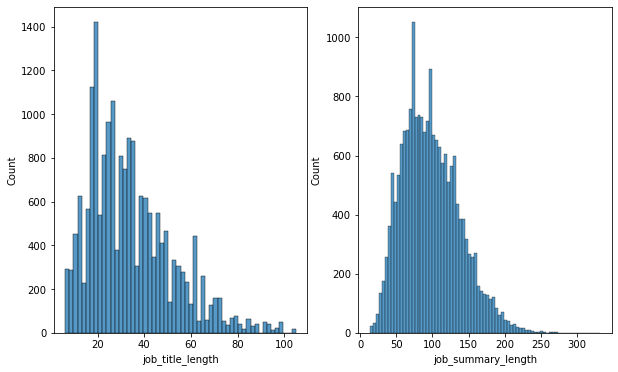

In [55]:
# let's plot a histogram of title and summary lenghs

fig, axs = plt.subplots(ncols=2,figsize=[10,6])

sns.histplot(data = job_desc_df, x = job_desc_df['job_title_length'], ax = axs[0])
sns.histplot(data = job_desc_df, x = job_desc_df['job_summary_length'], ax = axs[1])

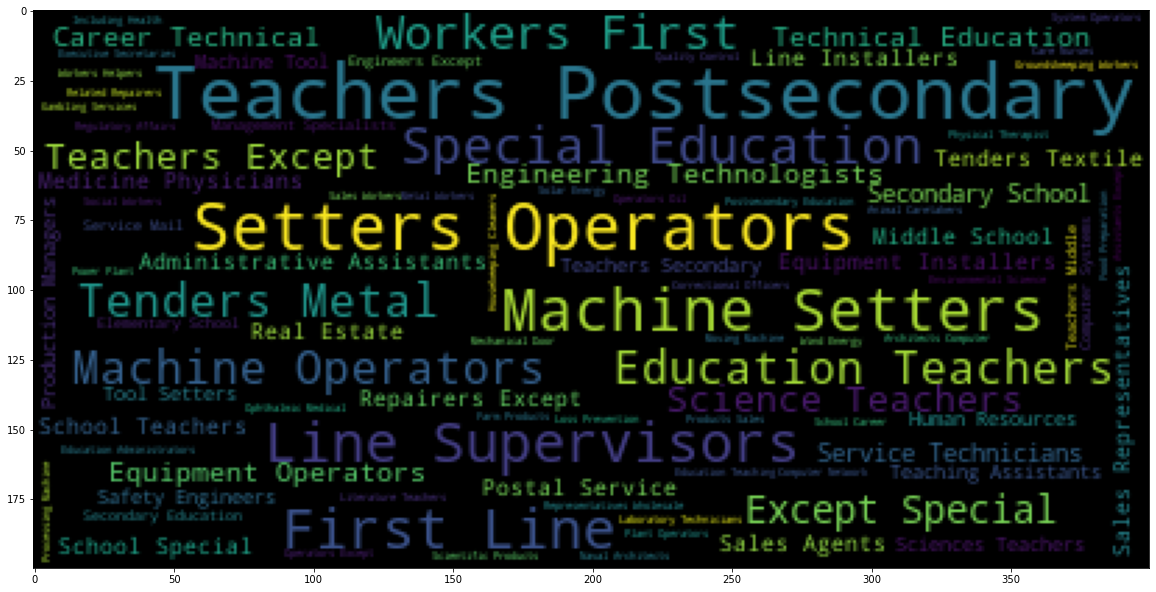

In [56]:
#creating a word cloud for Titles

titles = job_desc_df['Title'].tolist()
titles_as_one_string =" ".join(titles)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(titles_as_one_string))

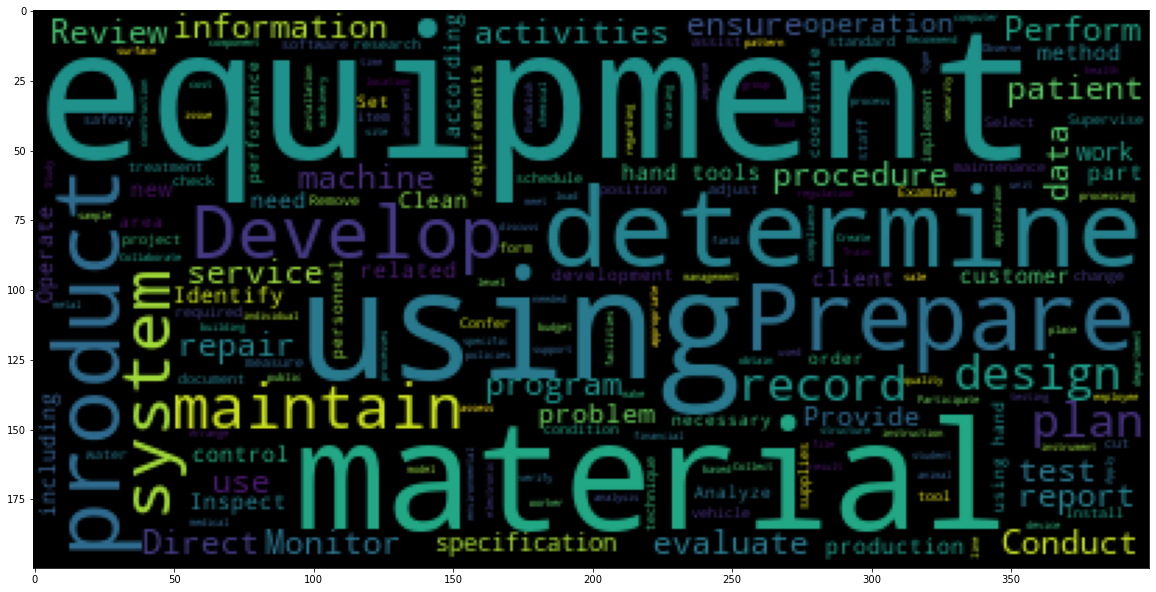

In [57]:
#creating a word cloud for Summary


descriptions = job_desc_df['Task'].tolist()
descriptions_as_one_string =" ".join(descriptions)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(descriptions_as_one_string))

#### Performing Non-Negtaive Matrix Factorization to get topic groups based on title

In [59]:
job_desc_df = job_desc_df.groupby(['Title'])['Task'].apply(','.join).reset_index()

In [60]:
title_tokens_job_df = clean_tokenize_text(job_desc_df,'Title', 'job_title_tokens')
title_tokens_job_df[['Title', 'job_title_tokens']].head()

,Title,job_title_tokens
0,Accountants and Auditors,"[account, auditor]"
1,Actors,[actor]
2,Actuaries,[actuari]
3,Acupuncturists,[acupuncturist]
4,Acute Care Nurses,"[acut, care, nurs]"


In [67]:
title_tokens_job_df.groupby(['Title'])['Title'].count()

Title
Accountants and Auditors                                              1
Actors                                                                1
Actuaries                                                             1
Acupuncturists                                                        1
Acute Care Nurses                                                     1
                                                                     ..
Wind Turbine Service Technicians                                      1
Woodworking Machine Setters, Operators, and Tenders, Except Sawing    1
Word Processors and Typists                                           1
Writers and Authors                                                   1
Zoologists and Wildlife Biologists                                    1
Name: Title, Length: 923, dtype: int64

In [68]:
tfidf = TfidfVectorizer(max_df=0.95, 
                        min_df=2, 
                        lowercase = True, 
                        stop_words="english",
                        ngram_range = (1,2), # include 2-word phrases
                        )

dtm = tfidf.fit_transform(title_tokens_job_df['job_title_tokens'].apply(lambda x: ' '.join(x)))

nmf_model = NMF(n_components=10, random_state=42)

nmf_model.fit(dtm)

C:\Users\Home\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=10, random_state=42)

In [69]:
# grabbing top 8 words per topic

for index,topic in enumerate(nmf_model.components_):
    print(f"The top 8 words for topric # {index}")
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-8:]])
    print('\n')

The top 8 words for topric # 0
['metal', 'oper', 'machin setter', 'setter oper', 'setter', 'machin', 'oper tender', 'tender']


The top 8 words for topric # 1
['special', 'educ teacher', 'educ', 'scienc', 'scienc teacher', 'teacher postsecondari', 'postsecondari', 'teacher']


The top 8 words for topric # 2
['transport', 'electr', 'mechan engin', 'technologist technician', 'architect', 'engin technologist', 'mechan', 'engin']


The top 8 words for topric # 3
['inform', 'gambl', 'servic', 'analyst', 'product manag', 'servic manag', 'product', 'manag']


The top 8 words for topric # 4
['servic', 'mechan', 'servic technician', 'medic', 'engin technologist', 'technologist technician', 'technologist', 'technician']


The top 8 words for topric # 5
['sale', 'materi', 'gambl', 'servic', 'line', 'line supervisor', 'supervisor', 'worker']


The top 8 words for topric # 6
['counter', 'ship', 'law', 'order', 'inform', 'product', 'account', 'clerk']


The top 8 words for topric # 7
['plant', 'oper

C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
description_tokens_job_df = clean_tokenize_text(job_desc_df,'Task', 'job_description_tokens')
description_tokens_job_df[['Task', 'job_description_tokens']].head()

,Task,job_description_tokens
0,"Prepare detailed reports on audit findings.,Report to management about asset utilization and audit results, and recommend changes in operations and financial activities.,Collect and analyze data to detect deficient controls, duplicated effort, extravagance, fraud, or non-compliance with laws, regulations, and management policies.,Inspect account books and accounting systems for efficiency, effectiveness, and use of accepted accounting procedures to record transactions.,Supervise auditing of establishments, and determine scope of investigation required.,Confer with company officials about financial and regulatory matters.,Examine and evaluate financial and information systems, recommending controls to ensure system reliability and data integrity.,Inspect cash on hand, notes receivable and payable, negotiable securities, and canceled checks to confirm records are accurate.,Examine records and interview workers to ensure recording of transactions and compliance with laws and regulations.,Prepare, examine, or analyze accounting records, financial statements, or other financial reports to assess accuracy, completeness, and conformance to reporting and procedural standards.,Prepare adjusting journal entries.,Review accounts for discrepancies and reconcile differences.,Establish tables of accounts and assign entries to proper accounts.,Examine inventory to verify journal and ledger entries.,Analyze business operations, trends, costs, revenues, financial commitments, and obligations to project future revenues and expenses or to provide advice.,Report to management regarding the finances of establishment.,Develop, implement, modify, and document recordkeeping and accounting systems, making use of current computer technology.,Evaluate taxpayer finances to determine tax liability, using knowledge of interest and discount rates, annuities, valuation of stocks and bonds, and amortization valuation of depletable assets.,Examine whether the organization's objectives are reflected in its management activities, and whether employees understand the objectives.,Audit payroll and personnel records to determine unemployment insurance premiums, workers' compensation coverage, liabilities, and compliance with tax laws.,Review taxpayer accounts, and conduct audits on-site, by correspondence, or by summoning taxpayer to office.,Compute taxes owed and prepare tax returns, ensuring compliance with payment, reporting, or other tax requirements.,Advise clients in areas such as compensation, employee health care benefits, the design of accounting or data processing systems, or long-range tax or estate plans.,Represent clients before taxing authorities and provide support during litigation involving financial issues.,Direct activities of personnel engaged in filing, recording, compiling, and transmitting financial records.,Conduct pre-implementation audits to determine if systems and programs under development will work as planned.,Develop, maintain, or analyze budgets, preparing periodic reports that compare budgeted costs to actual costs.,Prepare, analyze, or verify annual reports, financial statements, and other records, using accepted accounting and statistical procedures to assess financial condition and facilitate financial planning.,Process invoices for payment.,Review data about material assets, net worth, liabilities, capital stock, surplus, income, or expenditures.","[prepar, report, audit, report, manag, asset, util, audit, result, recommend, chang, oper, financi, activ, collect, analyz, data, detect, defici, control, duplic, effort, extravag, fraud, non, complianc, law, regul, manag, polici, inspect, account, book, account, effici, effect, accept, account, procedur, record, transact, supervis, audit, establish, determin, scope, investig, requir, confer, compani, offici, financi, regulatori, matter, examin, evalu, financi, inform, recommend, control, ensur, reliabl, data, integr, inspect, cash, hand, note, receiv, 

In [71]:
tfidf = TfidfVectorizer(max_df=0.95, 
                        min_df=2, 
                        lowercase = True, 
                        stop_words="english",
                        ngram_range = (1,2), # include 2-word phrases
                        )

dtm = tfidf.fit_transform(description_tokens_job_df['job_description_tokens'].apply(lambda x: ' '.join(x)))

# we will choose 5 topics to represent the 5 categories of courses 
nmf_model = NMF(n_components=10, random_state=42)

nmf_model.fit(dtm)

C:\Users\Home\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=10, random_state=42)

In [72]:
for index,topic in enumerate(nmf_model.components_):
    print(f"The top 8 words for topric # {index}")
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-8:]])
    print('\n')

The top 8 words for topric # 0
['plan', 'research', 'program', 'environment', 'data', 'project', 'design', 'develop']


The top 8 words for topric # 1


C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['profession', 'cours materi', 'research', 'grade', 'assign', 'cours', 'academ', 'student']


The top 8 words for topric # 2
['nurs', 'physician', 'therapi', 'health', 'care', 'treatment', 'medic', 'patient']


The top 8 words for topric # 3
['finish', 'metal', 'surfac', 'hand', 'cut', 'tool', 'workpiec', 'machin']


The top 8 words for topric # 4
['activ', 'administr', 'behavior', 'school', 'learn', 'children', 'teacher', 'student']


The top 8 words for topric # 5
['record', 'account', 'sale', 'financi', 'servic', 'inform', 'client', 'custom']


The top 8 words for topric # 6
['oper', 'power', 'tool', 'electr', 'test', 'instal', 'repair', 'equip']


The top 8 words for topric # 7
['materi product', 'oper', 'ingredi', 'qualiti', 'equip', 'process', 'materi', 'product']


The top 8 words for topric # 8
['breed', 'veterinarian', 'hors', 'pet', 'plant', 'diseas', 'feed', 'anim']


The top 8 words for topric # 9
['patron', 'dish', 'item', 'kitchen', 'menu', 'serv', 'cook', 'food']




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=39436d08-244a-48f2-9b52-ac5d3c551bf2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>